The goal of this project is to build and train a machine which can classify the different traffic signals on the street, which is also a basic steps for the self-driving.

Dataset Source: http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html

some of data set is for our model is from kaggle, and the link is shown above.

Link to this Collab workbook: https://drive.google.com/file/d/1Hqx37JIx_6nOHoi9Sy99Tb3NNLMHg5WY/view?usp=sharing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision
from torchvision import datasets, models, transforms 
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image 

#Data Processing#

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# locate file directory
file_directory = '/content/drive/MyDrive/Colab Notebooks/Project/crop_dataset/crop_dataset'   

In [4]:
# define image transform which will be used later in data loading. 64x64 was chosed rather than 224x224 due to occational low resolution.
im_transforms = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

In [5]:
# define hyperparametres, attempt data_loader function. Note this data_loader will not be used throughout.
batch_size = 16
num_workers = 1
dataset = torchvision.datasets.ImageFolder(file_directory, transform=im_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                      num_workers=num_workers, shuffle=True)

In [6]:
# train, valid, test seperation with ratio 6:2:2. Note that due to time limitation, data used is cut down to 1/10. 
indices = np.arange(len(dataset))
np.random.seed(1000) # set seed for reproducible results.
np.random.shuffle(indices)
train_data = int(len(indices) * 0.06)
valid_data = int(len(indices) * 0.02)
test_data = int(len(indices) * 0.02)

In [7]:
# split, convert datasets into dataloaders.
train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:valid_data+train_data+test_data] 

train_sampler = SubsetRandomSampler(train_indics)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=val_sampler)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=test_sampler)

In [8]:
print('Number of training data: ', len(train_loader.sampler))
print('Number of validation data: ', len(val_loader.sampler))
print('Number of test data: ', len(test_loader.sampler))

Number of training data:  1598
Number of validation data:  532
Number of test data:  532


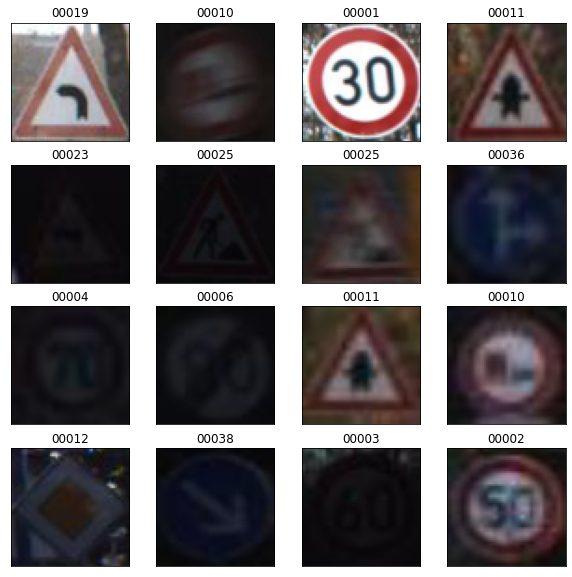

In [9]:
# Visualize a few sample images from the dataset, NOTE: CODES ADAPTED FROM TUTORIAL MATERIAL 

iter_data = iter(train_loader)
images, labels = iter_data.next()
images = images.numpy()

classes = ["00000", "00001", "00002","00003","00004","00005","00006","00007","00008","00009","00010","00011","00012","00013","00014","00015","00016","00017","00018","00019","00020","00021","00022","00023","00024","00025","00026","00027",
           "00028","00029","00030","00031","00032","00033","00034","00035","00036","00037","00038","00039","00040","00041","00042"]

fig = plt.figure(figsize=(10, 10))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 16/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#Testing Functions#

In [10]:
# ADAPTED FROM LAB 3
def get_accuracy(model, data_loader): 
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    output = model(imgs)
    
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

#Baseline Model#

This Baseline is a Convolutional Neuron Network with 2 convolutional layers, 2 pooling, and ANN classifiers. This is a common application in previous labs. Note the different number of classes seen from previous labs (<=9) and now (43 classes), this will cause significant descripencies between result from Baseline, and that of transfer learning.

In [11]:
def train(model, train_loader, val_loader, batch_size=256, 
              learning_rate=0.05, num_epochs=20): 
  
  torch.manual_seed(1000)
  
  #################################################################
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  iters, losses, train_acc, val_acc = [], [], [], []
  ##############################################################
  # training 
  n = 0 

  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader): 
      #############################################
      #To Enable GPU Usage
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
      out = model(imgs)                       # forward pass 
      loss = criterion(out, labels)           # compute the total loss 
      loss.backward()
      optimizer.step()                        # backward pass (compute para. update) 
      optimizer.zero_grad()                   # a clean up step for PyTorch 
      
    ##############################################################
    # save the current training info. 
    iters.append(n)
    losses.append(float(loss)/batch_size)

    train_acc.append(get_accuracy(model, train_loader))

    val_acc.append(get_accuracy(model, val_loader))
    print("epoch number ", epoch+1, "training accuracy: ",train_acc[epoch] , " and validation accuracy: ",val_acc[epoch])
    n+=1
  
  # plotting 
  plt.title ('Training Curve')
  plt.plot(iters, losses, label='Train')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label='Train')
  plt.plot(iters, val_acc, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Training Accuracy')
  plt.legend(loc='best')
  plt.show() 
  
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print('Final Validation Accuracy: {}'.format(val_acc[-1]))


In [12]:

class BASE(nn.Module): 
    def __init__(self):
        super(BASE, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(5, 10, 5) 
        self.conv3 = nn.Conv2d(10, 25, 5)                                   
        # self.fc1 = nn.Linear(24* 4* 4, 512)
        self.fc1 = nn.Linear(4* 25* 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear (128,43)   
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = x.view(-1, 4*25*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
use_cuda = True

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.06195244055068836  and validation accuracy:  0.043233082706766915
epoch number  2 training accuracy:  0.06195244055068836  and validation accuracy:  0.043233082706766915
epoch number  3 training accuracy:  0.06195244055068836  and validation accuracy:  0.043233082706766915
epoch number  4 training accuracy:  0.05131414267834793  and validation accuracy:  0.05451127819548872
epoch number  5 training accuracy:  0.05006257822277847  and validation accuracy:  0.046992481203007516
epoch number  6 training accuracy:  0.06195244055068836  and validation accuracy:  0.043233082706766915


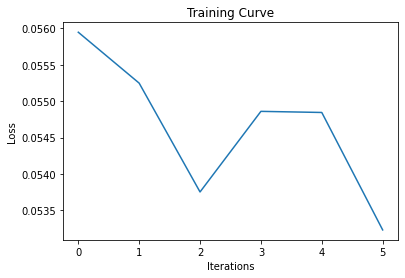

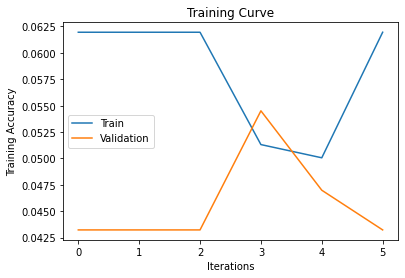

Final Training Accuracy: 0.06195244055068836
Final Validation Accuracy: 0.043233082706766915


In [15]:
Baseline_model = BASE()
if use_cuda and torch.cuda.is_available():
    Baseline_model.cuda()
    print('CUDA is available!  Training on GPU ...')

train (Baseline_model, train_loader, val_loader, batch_size=64, learning_rate=0.1, num_epochs=6)

In [16]:
print("Final test accuracy of the Baseline model is:", get_accuracy(Baseline_model, test_loader))

Final test accuracy of the Baseline model is: 0.05451127819548872


#Transfer Learning#
Performance of CNN baseline model is hardly satisfactory. Below is the application of pretrained models imported. These are to be brought into comparason with the Baseline to compare performance.

##GoogLeNet (Inception)##
Below is the model with transfer learning applied. For this section we introduced GoogleNet.

In [17]:
# Locating the dataset in the drive 
file_directory = '/content/drive/MyDrive/Colab Notebooks/Project/crop_dataset/crop_dataset'
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
# Dataloader preperation
batch_size = 64
num_workers = 1
dataset = datasets.ImageFolder(file_directory, transform=transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                      num_workers=num_workers, shuffle=True)

In [19]:
# Randomly separate the dataset into training, validation, and test set 
indices = np.arange(len(dataset))

# Split into train, validation and test dataset
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_data = int(len(indices) * 0.06) # Note that time limitation, we are only training on 1/10 of total dataset, 0.6 x 0.1 = 0.06.
valid_data = int(len(indices) * 0.02) 
test_data = int(len(indices) * 0.02)


In [20]:
# split, convert datasets into dataloaders.

train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:valid_data + train_data+test_data] 

G_train_sampler = SubsetRandomSampler(train_indics)
G_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_train_sampler)
G_val_sampler = SubsetRandomSampler(val_indices)
G_val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_val_sampler)
G_test_sampler = SubsetRandomSampler(test_indices)
G_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_test_sampler)

In [21]:
G_model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [22]:
use_cuda = True

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.6508135168961201  and validation accuracy:  0.575187969924812
epoch number  2 training accuracy:  0.8898623279098874  and validation accuracy:  0.8007518796992481
epoch number  3 training accuracy:  0.9524405506883604  and validation accuracy:  0.849624060150376
epoch number  4 training accuracy:  0.9643304130162703  and validation accuracy:  0.8703007518796992
epoch number  5 training accuracy:  0.9730913642052565  and validation accuracy:  0.8890977443609023


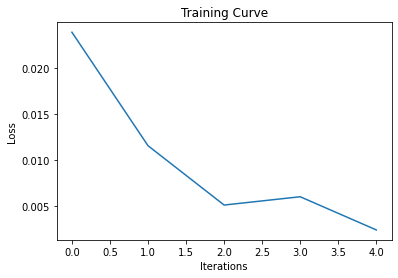

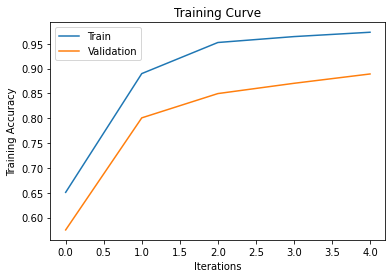

Final Training Accuracy: 0.9730913642052565
Final Validation Accuracy: 0.8890977443609023


In [23]:
if use_cuda and torch.cuda.is_available():
  G_model.cuda()
  print('CUDA is available!  Training on GPU ...')
 
train(G_model, G_train_loader, G_val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)

In [24]:
print("Final test accuracy of the GoogleNet model is:", get_accuracy(G_model, G_test_loader))

Final test accuracy of the GoogleNet model is: 0.9060150375939849


##Visual Geometry Group (VGG)##
Below is the model with transfer learning applied. For this section we introduced Visual Geometry Group (VGG). Different from as shown in presentation, this iteration yields particularly disapointing results compared to that of itself previously, or that of other models. We might have tweeked something wrong, but we are not sure. 

In [ ]:
# # identifying file location on google drive 
# file_directory = '/content/drive/MyDrive/Colab Notebooks/Project/crop_dataset/crop_dataset' 

In [ ]:
# # Resize and crop images into size 64 x 64
# transforms = transforms.Compose([
#     transforms.Resize(64),
#     transforms.CenterCrop(64),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [ ]:
# batch_size = 32
# num_workers = 1
# dataset = datasets.ImageFolder(file_directory, transform=transforms)

# data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                       num_workers=num_workers, shuffle=True)

In [ ]:
# indices = np.arange(len(dataset))
# # Split into train, validation and test dataset, only 10 percent of the total dataset will be used
# np.random.shuffle(indices)
# train_data = int(len(indices) * 0.06)  # Note that time limitation, we are only training on 1/10 of total dataset, 0.6 x 0.1 = 0.06.
# valid_data = int(len(indices) * 0.02)
# test_data = int(len(indices) * 0.02)

In [ ]:
# # split, convert datasets into dataloaders.

# train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:valid_data+train_data+test_data] 

# vgg_train_sampler = SubsetRandomSampler(train_indics)
# vgg_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                       num_workers=num_workers, sampler=vgg_train_sampler)
# vgg_val_sampler = SubsetRandomSampler(val_indices)
# vgg_val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                       num_workers=num_workers, sampler=vgg_val_sampler)
# vgg_test_sampler = SubsetRandomSampler(test_indices)
# vgg_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                       num_workers=num_workers, sampler=vgg_test_sampler)

In [ ]:
# vgg_model = models.vgg16(pretrained=True)

In [ ]:
# if use_cuda and torch.cuda.is_available():
#   vgg_model.cuda()
#   print('CUDA is available!  Training on GPU ...')
 
# train(vgg_model, vgg_train_loader, vgg_val_loader, batch_size=batch_size, learning_rate=0.01, num_epochs=6)


In [ ]:
# print("Final test accuracy of the VGG model is:", get_accuracy(vgg_model, vgg_test_loader))

##ResNet##

In [25]:
resnet_model = models.resnet.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 43)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.5444305381727159  and validation accuracy:  0.5639097744360902
epoch number  2 training accuracy:  0.7377972465581978  and validation accuracy:  0.693609022556391
epoch number  3 training accuracy:  0.8585732165206508  and validation accuracy:  0.8176691729323309
epoch number  4 training accuracy:  0.9211514392991239  and validation accuracy:  0.8834586466165414
epoch number  5 training accuracy:  0.9136420525657072  and validation accuracy:  0.900375939849624


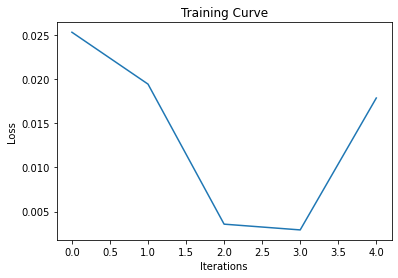

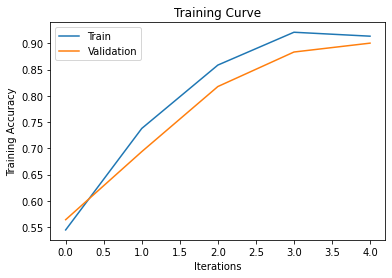

Final Training Accuracy: 0.9136420525657072
Final Validation Accuracy: 0.900375939849624


In [26]:
# Train the ResNet by tuning hyperparameters 
if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')

train(resnet_model, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)

In [27]:
print("Final test accuracy of the ResNet model is:", get_accuracy(resnet_model, test_loader))

Final test accuracy of the ResNet model is: 0.8665413533834586


##Demonstration##
Harry's Part, In this section, he will perform demonstrations with his generated datasets.

In [28]:
demon_dir = '/content/drive/MyDrive/Colab Notebooks/Project/test_dataset'  
dataset = datasets.ImageFolder(demon_dir, transform=im_transforms)
demon_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


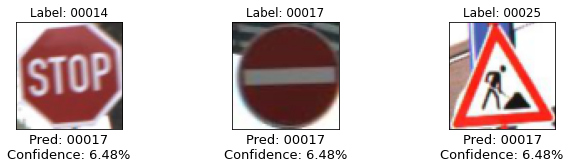

In [46]:
# Demonstrate the Baseline model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(Baseline_model(image.cuda())).tolist())

# obtain one batch of training images
iter_data = iter(demon_loader)
images, labels = iter_data.next()
images = images.numpy() # convert images to numpy for display

classes = ["00014", "00017", "00025"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))]
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

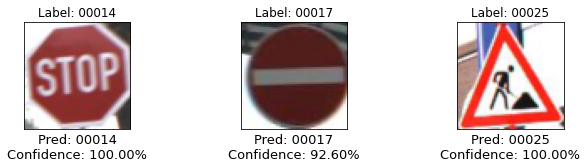

In [63]:
# Demonstrate the GoogLeNet model 
# pred = [] 
# for image, label in demon_loader: 
#   pred.append(F.softmax(G_model(image.cuda())).tolist())


# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["00014", "00017", "00025"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)
    

In [ ]:
# Demonstrate the VGG model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(vgg16(image.cuda())).tolist())

# obtain one batch of training images
iter_data = iter(demon_loader)
images, labels = iter_data.next()
images = images.numpy() # convert images to numpy for display

classes = ["00014", "00017", "00025"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


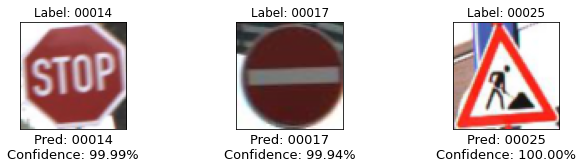

In [64]:
# Demonstrate the ResNet model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(resnet_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["00014", "00017", "00025"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

In [65]:
# # Demonstrate the Reference model 
# pred = [] 
# for image, label in demon_loader: 
#   pred.append(F.softmax(ref_model(image.cuda())).tolist())

# # obtain one batch of training images
# iter_data = iter(demon_loader)
# images, labels = iter_data.next()
# images = images.numpy() # convert images to numpy for display

# classes = ["00014", "00017", "00025"]

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(11, 9))
# for idx in range(len(images)):
#     ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title("Label: " + classes[labels[idx]])
#     ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
#                   + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

In [ ]:
!jupyter nbconvert --to html''